# Example: User-controlled HDF5 File Names with EPICS Area Detector

Setup the EPICS Area Detector HDF5 plugin as an *ophyd*-style object for data acquisition.  Demonstrate the plugin by acquiring an image with a bluesky plan and then plotting the image from the databroker catalog.

Override the default ophyd naming process (which uses random [UUIDs](https://docs.python.org/3/library/uuid.html#uuid.uuid4)) for image files.  Instead, let the user control the image file name using the features of the EPICS Area Detector HDF5 plugin.

We'll use the EPICS Area Detector [ADSimDetector](https://github.com/areaDetector/ADSimDetector) as provided in an EPICS IOC (server) running on your own network.  The IOC prefix is `ad:`.  We leave the details of creating and running the IOC to you.  (One way is to use a [docker container](https://github.com/prjemian/epics-docker/tree/main/v1.1/n6_custom_areaDetector#readme).)  This document is focused on the HDF5 plugin.  It could be used with any other camera support fomr EPICS area detector, with matching support from ophyd.  Also, many of the details of the HDF5 plugin are shared by other area detector file writing plugins, such as JPEG or TIFF.  This document could be used as a guide when using one of those plugins.

## Prepare the Ophyd Device

An ophyd Device is used to connect bluesky data acquisition plans (in Python) with EPICS IOC process variables (PVs).

### Imports

First, we must import the Python libraries needed here to create the *ophyd*-style object.

In [1]:
from apstools.devices import AD_EpicsFileNameHDF5Plugin
from apstools.devices import AD_full_file_name_local
from apstools.devices import AD_prime_plugin2
from ophyd import EpicsSignalWithRBV
from ophyd.areadetector import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector import SingleTrigger
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin
from ophyd.areadetector.plugins import PvaPlugin_V34 as PvaPlugin
from ophyd.areadetector import SimDetectorCam
import pathlib
import time

### Local Details

For simplicity later, we define details of the local system here.

variable | description
--- | ---
`IOC` | EPICS IOC prefix of the ADSimDetector instance
`IMAGE_DIR` | Subdirectory of `*_MOUNT_PATH` for image files.
`AD_IOC_MOUNT_PATH` | File system mount point, as seen by the EPICS IOC.
`BLUESKY_MOUNT_PATH` | File system mount point, as seen by Python.

It is important to understand that, while the EPICS IOC and the Python process where the user interacts (with bluesky and databroker) should both see the same image file written by acquisition, the directory path to that file may be different on the two systems.  Typically, the file system is mounted on both (IOC & Python) at the time of acquisition, perhaps at different mount points on each.  Alternatively, the image file written by the IOC may be copied to a directory where Python can find the file **when** the user attempts to read image data via databroker.

Note: the EPICS Area Detector HDF5 Plugin support will convert date/time symbols (such as `%Y/%m/%d`) at the time of acquisition.

In [2]:
IOC = "ad:"
IMAGE_DIR = "adsimdet/%Y/%m/%d"
AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

### Paths

These two strings will be used to create the initial detector class and may also be used by the user later.

In [3]:
# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

### Update the Cam plugin support

For the `ophyd.SimDetectorCam` (and possibly other detector cam support), we must modify for upstream changes in the `ADSimDetector` IOC.  Here, we remove `pool_max_buffers` (from changes with `ADCore` release 3.1.1) and add `offset`.

In [4]:
class SimDetectorCam_R3_1_1(SimDetectorCam):
    """Revise SimDetectorCam for ADcore revisions."""
    pool_max_buffers = None
    offset = ADComponent(EpicsSignalWithRBV, "Offset")

### Detector Class

In this demo, we only configure the `cam` (`ADSimDetector` itself) and `hdf1` plugins.  Additional configuration for `image` and PVAccess plugins are shown in comments, should you want to add them.  The system is very modular.

The plugin name we use here, `hdf1`, is customary.

NOTE: Here is where we apply the customization **necessary** for the user to control the HDF5 image file names, using the `apstools.devices.AD_EpicsFileNameHDF5Plugin` class.  (The real work is done in `apstools.devices.area_detector_support.AD_EpicsFileNameMixin()` if you want to see the details.)  We repeat certain cautionary details here:

> Replace standard ophyd file naming algorithm (where file names are defined as UUID strings, virtually guaranteeing that no existing images files will ever be overwritten).
> 
> Caller is responsible for setting values of these Components of the plugin:
> 
>- `array_counter`
>- `auto_increment`
>- `auto_save`
>- `compression` (only the HDF plugin)
>- `create_directory`
>- `file_name`
>- `file_number`
>- `file_path`
>- `file_template`
>- `num_capture`

Also note:

> It is allowed to set `file_template="%s%s.h5"` so the file name does not include the file number.


In [5]:
class MySimDetector(SingleTrigger, DetectorBase):
    """ADSimDetector"""

    cam = ADComponent(SimDetectorCam_R3_1_1, "cam1:")
    hdf1 = ADComponent(
        AD_EpicsFileNameHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    # image = ADComponent(ImagePlugin, "image1:")
    # pva = ADComponent(PvaPlugin, "Pva1:")

### Detector Object

A Python object is necessary to connect with the EPICS IOC.

In [6]:
adsimdet = MySimDetector(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)

### Prime the plugin

This is only needed when the image metadata in the `cam` is different than the `hdf1` plugin.

In some cases (such as when the IOC has just been started), it is necessary to *Prime* (or *warmup*) the HDF5 plugin.  To prime, process one EPICS Area Detector frame (NDArray) from `cam` to `hdf1`, so that the HDF5 plugin will know the proper image metadata (number of pixels, bit depth, ...) when first creating the HDF5 file.  We call `apstools.devices.AD_prime_plugin2(PLUGIN)` to prime the plugin.

Note:  There is a `lazy_open` attribute that could avoid this step but the ophyd support also must know this _before_ image acquisition.

In [7]:
AD_prime_plugin2(adsimdet.hdf1)

### Configure

As noted above, the caller is now responsible for setting various values of the plugin.  (And, we're just assuming the data acquisition time, in `cam`, has been set properly.)

In [8]:
# these settings are the caller's responsibility
adsimdet.hdf1.create_directory.put(-5)
adsimdet.hdf1.file_path.put(WRITE_PATH_TEMPLATE)  # path that the IOC will write the file
adsimdet.hdf1.file_template.put(f"%s%s_%4.4d.h5")
adsimdet.hdf1.file_name.put("my_test_file")
adsimdet.hdf1.auto_increment.put("Yes")
adsimdet.hdf1.auto_save.put("Yes")
adsimdet.hdf1.compression.put("zlib")
adsimdet.hdf1.zlevel.put(6)

Add the plugin by name to the detector's `read_attrs` so the plugin's `.read()` method is called during data acquisition.

In [9]:
adsimdet.read_attrs.append("hdf1")

### Try it

Test that the customizations actually work by staging and triggering the detector.  Wait for acquisition to finish, then unstage.

In [10]:
adsimdet.stage()
adsimdet.trigger()
time.sleep(0.005)
while adsimdet.cam.acquire.get(use_monitor=False) not in (0, "Done"):
    time.sleep(0.005)
adsimdet.unstage()

Let's see the name of the acquired image file, as seen by the detector and IOC.  We do not expect Python to find that it exists.

In [11]:
ffname = pathlib.Path(adsimdet.hdf1.full_file_name.get(use_monitor=False))
print(f"{ffname.exists()=}\n{ffname=}")

ffname.exists()=False
ffname=PosixPath('/tmp/adsimdet/2022/07/06/my_test_file_0147.h5')


Now see the name of the same file as seen by Python and the databroker.  We expect that this file exists.

In [12]:
lfname = AD_full_file_name_local(adsimdet.hdf1)
print(f"{lfname.exists()=}\n{lfname=}")

lfname.exists()=True
lfname=PosixPath('/tmp/docker_ioc/iocad/tmp/adsimdet/2022/07/06/my_test_file_0147.h5')


## Acquire with Bluesky Plan

Within the [Bluesky framework](https://blueskyproject.io/), `bluesky` is the package that orchestrates the data acquisition steps, including where to direct acquired data for storage.  We'll use `databroker` to manage the stored data.

### Imports

Configure MatPlotLib to visualize graphical results from Bluesky scans, then import the libraries we will use.

In [13]:
# Import matplotlib and put it in interactive mode.
%matplotlib widget
import matplotlib.pyplot as plt
plt.ion()

from bluesky import plans as bp
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
import databroker

### Configure

We'll use a temporary databroker catalog for this example.  You may wish to use your own catalog: `cat = databroker.catalog[YOUR_CATALOG_NAME]`.  Then setup the run engine `RE`.

In [14]:
cat = databroker.temp().v2
RE = RunEngine({})

RE.subscribe(cat.v1.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(SupplementalData())

### Acquire

Take an image with the area detector and capture the list of identifiers (there will be only one item).  Add custom metadata to identify the imaging run.

In [15]:
uids = RE(bp.count([adsimdet], md=dict(title="how to setup HDF5 plugin", purpose="image")))



Transient Scan ID: 1     Time: 2022-07-06 13:37:08
Persistent Unique Scan ID: 'ad014dd5-037d-4fd6-8814-b39d29138811'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 13:37:09.1 |
+-----------+------------+
generator count ['ad014dd5'] (scan num: 1)





## Access the Image with Databroker

To get the run information from the databroker catalog, we *could* assume the run we want is the most recent one in the catalog, using: `run = cat.v2[-1]`.  But, since we have a list of run uid strings, let's use that instead.  We called the `RE` with `bp.count()`, which only generates a single run, so there is no assumption here.

### Get the run from the catalog

In [16]:
run = cat.v2[uids[0]]

### Get the image frame from the run

From the run, we know the image data is in the *primary* stream, recorded under the name `"adsimdet_image"`.  This image object has rank of 4. We just want the image frame (the last two indices). Select the first item of each of the first two indices (time, frame number).

In [17]:
dataset = run.primary.read()
image = dataset["adsimdet_image"]
frame = image[0][0]

### Visualize the image

The `frame` is an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), which has a method to visualize the data as shown here:

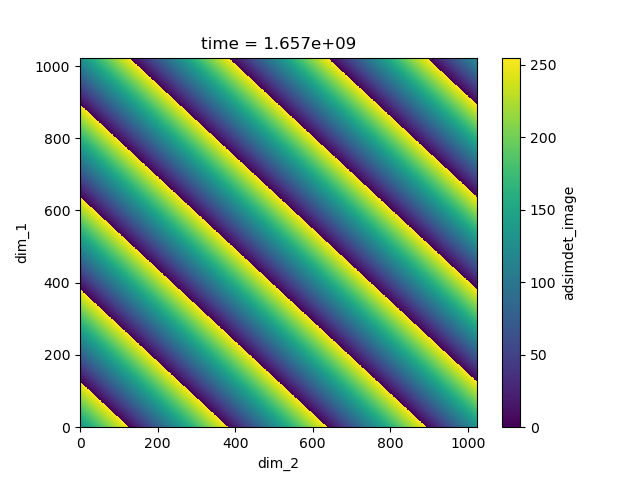

In [18]:
frame.plot.pcolormesh()